# Imports

In [3]:
from google.colab import drive
from lxml import etree
import os
import numpy as np
from PIL import Image, ImageDraw
from numpy import asarray

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense

from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Sample train image

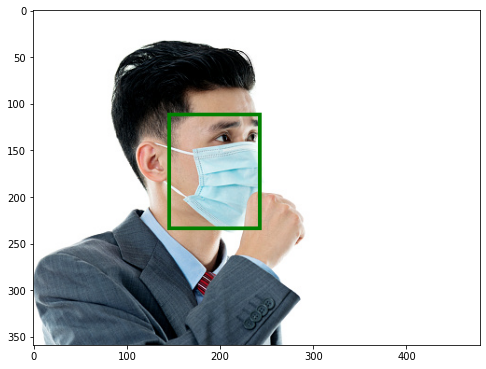

In [5]:
fig = plt.figure(figsize=(8,8))
img = Image.open('/content/drive/MyDrive/Face mask detection/images/maksssksksss142.png')
tree = etree.parse('/content/drive/MyDrive/Face mask detection/annotations/maksssksksss142.xml')
xmin, ymin, xmax, ymax = tree.xpath('//xmin/text()'), tree.xpath('//ymin/text()'), tree.xpath('//xmax/text()'), tree.xpath('//ymax/text()')

for i in range(len(xmin)):
    draw = ImageDraw.Draw(img)
    x1,y1, x2,y2 = int(xmin[i]), int(ymin[i]) , int(xmax[i]), int(ymax[i])
    draw.rectangle(((x1,y1), (x2, y2)), outline="green", width=4)

plt.imshow(img)
plt.show()

# Loading data into X and Y from google drive

In [6]:
xmls = os.listdir('/content/drive/MyDrive/Face mask detection/annotations')

In [7]:
X = []
Y = []
initial = 1
for xml in xmls:
    xmlFile = "/content/drive/MyDrive/Face mask detection/annotations/" + xml
    pngFile = "/content/drive/MyDrive/Face mask detection/images/" + xml[:-4] + ".png"
    tree = etree.parse(xmlFile)
    PilImage = Image.open(pngFile)

    RGBImage = PilImage.convert('RGB')

    maskType, xmin, ymin, xmax, ymax = tree.xpath('//name/text()'), tree.xpath('//xmin/text()'), tree.xpath('//ymin/text()'), tree.xpath('//xmax/text()'), tree.xpath('//ymax/text()')

    for i in range(len(maskType)):
        if maskType[i] == 'with_mask':
            Y.append(1)
        else:
            Y.append(0)
        cropped = asarray(RGBImage.crop(( int(xmin[i]), int(ymin[i]) , int(xmax[i]), int(ymax[i]) )).resize((128,128)))
        X.append(cropped)
    
    print(str(initial) + ' images loaded') if initial % 50 == 0 else None 
    initial += 1

X = np.stack(X,axis=0)
Y = np.array(Y)

50 images loaded
100 images loaded
150 images loaded
200 images loaded
250 images loaded
300 images loaded
350 images loaded
400 images loaded
450 images loaded
500 images loaded
550 images loaded
600 images loaded
650 images loaded
700 images loaded
750 images loaded
800 images loaded
850 images loaded


# Sample cropped image with label and size

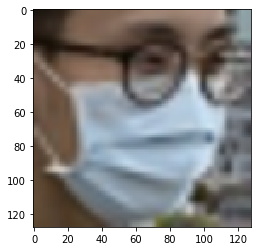

Label 1
Shape (128, 128, 3)


In [8]:
index = 90
plt.imshow(X[index], interpolation='nearest')
plt.show()
print('Label ' + str(Y[index]))
print('Shape ' + str(X[index].shape))

In [9]:
X.shape

(4072, 128, 128, 3)

In [10]:
Y.shape

(4072,)

# Train-Test Split

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Generator for Image Augmentation

In [12]:
datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)

augmented_X = []
augmented_Y = []
num_augmented = 0
batch_size = 32
limit = 4000*2

for X_batch, Y_batch in datagen.flow(X_train, Y_train, batch_size=batch_size, shuffle=False):
    augmented_X.append(X_batch)
    augmented_Y.append(Y_batch)
    
    num_augmented += batch_size
    if num_augmented > limit:
        break

augmented_X = np.concatenate(augmented_X)
augmented_Y = np.concatenate(augmented_Y)

In [13]:
X_train_aug = np.concatenate([X_train,augmented_X])
Y_train_aug = np.concatenate([Y_train,augmented_Y])

In [14]:
X_train_aug.shape

(11275, 128, 128, 3)

In [15]:
Y_train_aug.shape

(11275,)

# Downloading VGG19 pre-trained model

In [18]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
Model = Sequential()
Model.add(vgg19)
Model.add(Flatten())
Model.add(Dense(2,activation='sigmoid'))
Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 16386     
                                                                 
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [19]:
Model.compile(optimizer='Adam',loss="sparse_categorical_crossentropy",metrics =["accuracy"])
# early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)
history = Model.fit(x=X_train_aug, y=Y_train_aug, batch_size=128, epochs=12, validation_data=(X_val,Y_val), verbose=1) # , callbacks=[early_stopping]

Epoch 1/12
89/89 [==============================] - 45s 439ms/step - loss: 0.7661 - accuracy: 0.8166 - val_loss: 0.9684 - val_accuracy: 0.9337
Epoch 2/12
89/89 [==============================] - 39s 437ms/step - loss: 0.3526 - accuracy: 0.8617 - val_loss: 1.0796 - val_accuracy: 0.9264
Epoch 3/12
89/89 [==============================] - 39s 437ms/step - loss: 0.2696 - accuracy: 0.8856 - val_loss: 1.0067 - val_accuracy: 0.9239
Epoch 4/12
89/89 [==============================] - 39s 438ms/step - loss: 0.2707 - accuracy: 0.8903 - val_loss: 1.0813 - val_accuracy: 0.9301
Epoch 5/12
89/89 [==============================] - 39s 437ms/step - loss: 0.2243 - accuracy: 0.9077 - val_loss: 1.1548 - val_accuracy: 0.9239
Epoch 6/12
89/89 [==============================] - 39s 437ms/step - loss: 0.2055 - accuracy: 0.9145 - val_loss: 1.1274 - val_accuracy: 0.9387
Epoch 7/12
89/89 [==============================] - 39s 437ms/step - loss: 0.1956 - accuracy: 0.9212 - val_loss: 1.2054 - val_accuracy: 0.9362

# Training graph

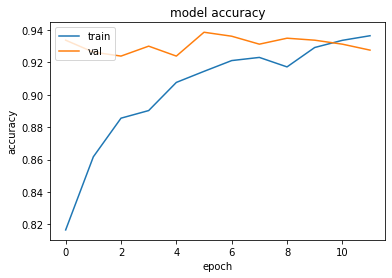

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()